# Diffusion Inversion

This notebook contains a minimalist implementation of diffusion inversion using the DDIM formulation.  Diffusion model train a neural network to map Gaussian noise to an image, but once that neural network is trained, what if we want to know what noise was used to generate a specific image?  For this we can use the a process called diffusion inversion which maps a real image to Gaussian noise.

The code here is based on the tutorial found here: https://huggingface.co/learn/diffusion-course/en/unit4/2

# Setup

Library import go here.

In [1]:
import torch
import requests
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from io import BytesIO
from tqdm.auto import tqdm
from matplotlib import pyplot as plt
from torchvision import transforms as tfms
from diffusers import StableDiffusionPipeline, DDIMScheduler

Download an example image.

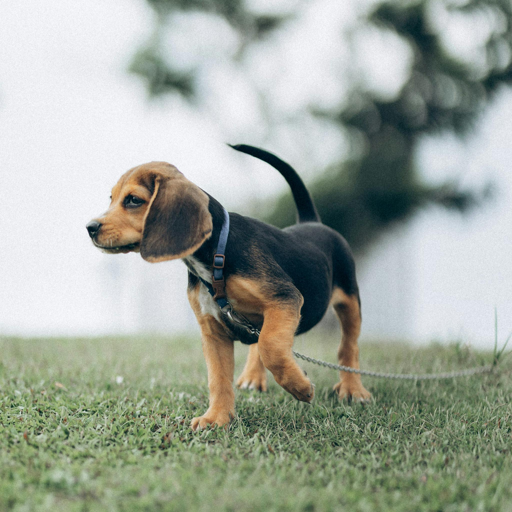

In [2]:
def load_image(url, size=None):
    response = requests.get(url, timeout=0.2)
    img = Image.open(BytesIO(response.content)).convert("RGB")
    if size is not None:
        img = img.resize(size)
    return img

input_image = load_image("https://images.pexels.com/photos/8306128/pexels-photo-8306128.jpeg", size=(512, 512))
input_image

# Download Model

The diffusion model we will use in this notebook is Stable Diffusion v1.4.  You will need internet access to download this model which can be found at: https://huggingface.co/stable-diffusion-v1-5/stable-diffusion-v1-5

In [3]:
# Download stable diffusion
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
pipe = StableDiffusionPipeline.from_pretrained("stable-diffusion-v1-5/stable-diffusion-v1-5").to(device)
pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

safety_checker/model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

# Inversion Algorithm

To run both sampling (i.e. generation) and diffusion inversion, we use the following DDIM equation:

$$\boldsymbol{x}_{t-1}=\sqrt{\alpha_{t-1}} \left( \frac{\boldsymbol{x}_t-\sqrt{1-\alpha_t}\epsilon_{\theta}(x_t,t)}{\sqrt{\alpha_t}} \right) + \sqrt{1-\alpha_{t-1}-\sigma} \epsilon_{\theta}(x_t,t) + \sigma z$$

where $t$ is the timestep, $x_t$ is a noisy image, $\epsilon_{\theta}$ is the diffusion network, and $\alpha_t$ is the noise schedule. $z$ is addition Gaussian noise, however for our case we will set $\sigma=0$ meaning we can ignore it.

In [4]:
# Sample function (regular DDIM)
@torch.no_grad()
def sample(
    prompt,
    start_step=0,
    start_latents=None,
    guidance_scale=3.5,
    num_inference_steps=30,
    num_images_per_prompt=1,
    do_classifier_free_guidance=True,
    negative_prompt="",
    device=device,
):

    # Encode prompt
    text_embeddings = pipe._encode_prompt(
        prompt, device, num_images_per_prompt, do_classifier_free_guidance, negative_prompt
    )

    # Set num inference steps
    pipe.scheduler.set_timesteps(num_inference_steps, device=device)

    # Create a random starting point if we don't have one already
    if start_latents is None:
        start_latents = torch.randn(1, 4, 64, 64, device=device)
        start_latents *= pipe.scheduler.init_noise_sigma

    latents = start_latents.clone()

    for i in tqdm(range(start_step, num_inference_steps)):

        t = pipe.scheduler.timesteps[i]

        # Expand the latents if we are doing classifier free guidance
        latent_model_input = torch.cat([latents] * 2) if do_classifier_free_guidance else latents
        latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)

        # Predict the noise residual
        noise_pred = pipe.unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

        # Perform guidance
        if do_classifier_free_guidance:
            noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
            noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # Normally we'd rely on the scheduler to handle the update step:
        # latents = pipe.scheduler.step(noise_pred, t, latents).prev_sample

        # Instead, let's do it ourselves:
        prev_t = max(1, t.item() - (1000 // num_inference_steps))  # t-1
        alpha_t = pipe.scheduler.alphas_cumprod[t.item()]
        alpha_t_prev = pipe.scheduler.alphas_cumprod[prev_t]
        predicted_x0 = (latents - (1 - alpha_t).sqrt() * noise_pred) / alpha_t.sqrt()
        direction_pointing_to_xt = (1 - alpha_t_prev).sqrt() * noise_pred
        latents = alpha_t_prev.sqrt() * predicted_x0 + direction_pointing_to_xt

    # Post-processing
    images = pipe.decode_latents(latents)
    images = pipe.numpy_to_pil(images)

    return images

In [5]:
## Inversion
@torch.no_grad()
def invert(
    start_latents,
    prompt,
    guidance_scale=3.5,
    num_inference_steps=80,
    num_images_per_prompt=1,
    do_classifier_free_guidance=True,
    negative_prompt="",
    device=device,
):

    # Encode prompt
    text_embeddings = pipe._encode_prompt(
        prompt, device, num_images_per_prompt, do_classifier_free_guidance, negative_prompt
    )

    # Latents are now the specified start latents
    latents = start_latents.clone()

    # We'll keep a list of the inverted latents as the process goes on
    intermediate_latents = []

    # Set num inference steps
    pipe.scheduler.set_timesteps(num_inference_steps, device=device)

    # Reversed timesteps <<<<<<<<<<<<<<<<<<<<
    timesteps = reversed(pipe.scheduler.timesteps)

    for i in tqdm(range(1, num_inference_steps), total=num_inference_steps - 1):

        # We'll skip the final iteration
        if i >= num_inference_steps - 1:
            continue

        t = timesteps[i]

        # Expand the latents if we are doing classifier free guidance
        latent_model_input = torch.cat([latents] * 2) if do_classifier_free_guidance else latents
        latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)

        # Predict the noise residual
        noise_pred = pipe.unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

        # Perform guidance
        if do_classifier_free_guidance:
            noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
            noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        current_t = max(0, t.item() - (1000 // num_inference_steps))  # t
        next_t = t  # min(999, t.item() + (1000//num_inference_steps)) # t+1
        alpha_t = pipe.scheduler.alphas_cumprod[current_t]
        alpha_t_next = pipe.scheduler.alphas_cumprod[next_t]

        # Inverted update step (re-arranging the update step to get x(t) (new latents) as a function of x(t-1) (current latents)
        latents = (latents - (1 - alpha_t).sqrt() * noise_pred) * (alpha_t_next.sqrt() / alpha_t.sqrt()) + (
            1 - alpha_t_next
        ).sqrt() * noise_pred

        # Store
        intermediate_latents.append(latents)

    return torch.cat(intermediate_latents)

# Run Inversion

Here we will find the noise that could have generated our image.

/usr/local/lib/python3.12/dist-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:313: FutureWarning: `_encode_prompt()` is deprecated and it will be removed in a future version. Use `encode_prompt()` instead. Also, be aware that the output format changed from a concatenated tensor to a tuple.
  deprecate("_encode_prompt()", "1.0.0", deprecation_message, standard_warn=False)


  0%|          | 0/49 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:599: FutureWarning: The decode_latents method is deprecated and will be removed in 1.0.0. Please use VaeImageProcessor.postprocess(...) instead
  deprecate("decode_latents", "1.0.0", deprecation_message, standard_warn=False)


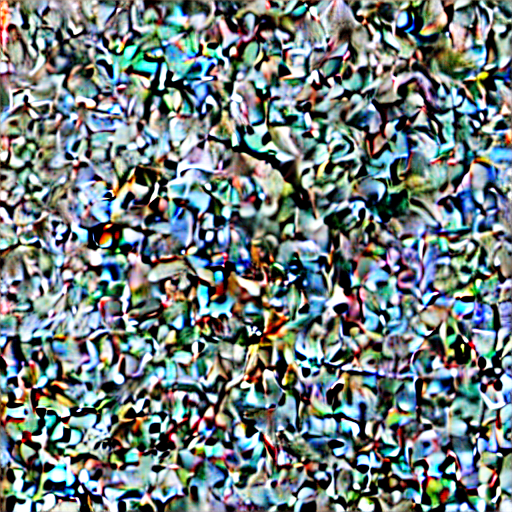

In [6]:
# Encode image with VAE
with torch.no_grad():
    latent = pipe.vae.encode(tfms.functional.to_tensor(input_image).unsqueeze(0).to(device) * 2 - 1)
l = 0.18215 * latent.latent_dist.sample()

# Invert image
input_image_prompt = "Photograph of a puppy on the grass"
inverted_latents = invert(l, input_image_prompt, num_inference_steps=50)

# Decode the final inverted latents
with torch.no_grad():
    im = pipe.decode_latents(inverted_latents[-1].unsqueeze(0))
pipe.numpy_to_pil(im)[0]

Next, lets run use this noise regenerate our image.

  0%|          | 0/50 [00:00<?, ?it/s]

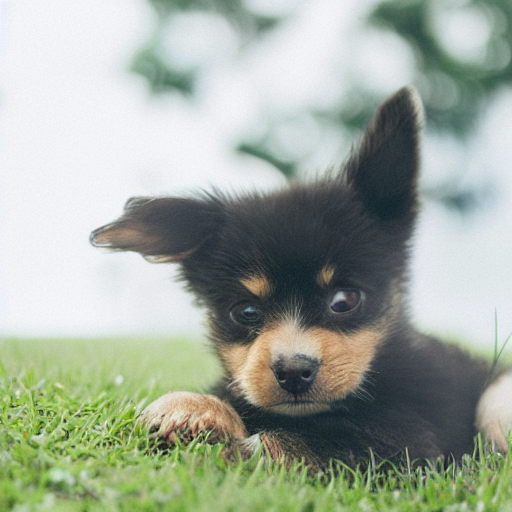

In [7]:
pipe(input_image_prompt, latents=inverted_latents[-1][None], num_inference_steps=50, guidance_scale=3.5).images[0]

This isn't quite right. This is because diffusion inversion required multiple steps (50 in our case) and at each step, a certain amount of error accumulates.  To resolve this, we start generation not from the original noise x_T, but from a middle point along th diffusion inversion trajectory.

  0%|          | 0/30 [00:00<?, ?it/s]

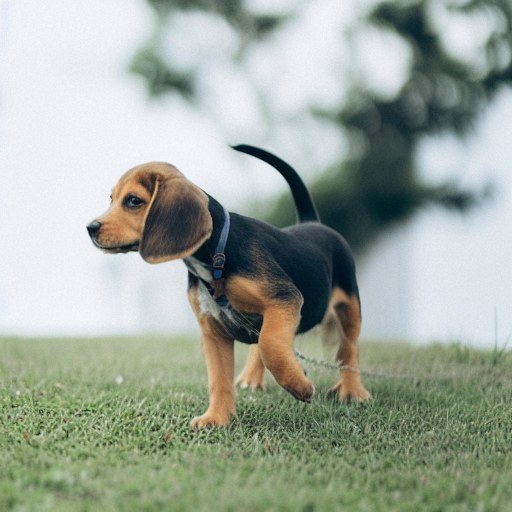

In [8]:
# The reason we want to be able to specify start step
start_step = 20
sample(
    input_image_prompt,
    start_latents=inverted_latents[-(start_step + 1)][None],
    start_step=start_step,
    num_inference_steps=50,
)[0]

This even allows us to make edit by changing our input prompt.

  0%|          | 0/40 [00:00<?, ?it/s]

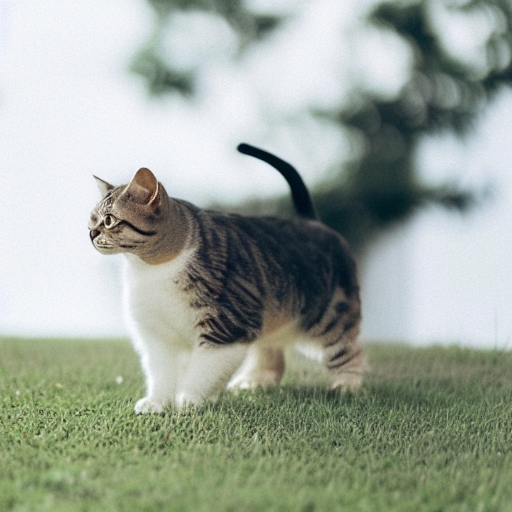

In [9]:
# Sampling with a new prompt
start_step = 10
new_prompt = input_image_prompt.replace("puppy", "cat")
sample(
    new_prompt,
    start_latents=inverted_latents[-(start_step + 1)][None],
    start_step=start_step,
    num_inference_steps=50,
)[0]